In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import time
import platform
import psutil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [2]:
# Datensatz laden
file_path = r"C:\Users\leesh\Desktop\BA\Datensätze\cardiovascular_disease_dataset\anonymized_datasets\cvd_k100_l2-anonymized.csv"
df = pd.read_csv(file_path, delimiter=";", low_memory=False)

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68184 entries, 0 to 68183
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           68184 non-null  object
 1   age          68184 non-null  object
 2   gender       68184 non-null  object
 3   height       68184 non-null  object
 4   weight       68184 non-null  object
 5   ap_hi        68184 non-null  object
 6   ap_lo        68184 non-null  object
 7   cholesterol  68184 non-null  object
 8   gluc         68184 non-null  object
 9   smoke        68184 non-null  object
 10  alco         68184 non-null  object
 11  active       68184 non-null  object
 12  cardio       68184 non-null  int64 
dtypes: int64(1), object(12)
memory usage: 6.8+ MB
None


In [4]:
def process_value(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        value = value.strip()
        if value.startswith('[') and value.endswith('['):
            try:
                start, end = map(float, value[1:-1].split(','))
                return (start + end) / 2
            except ValueError:
                return np.nan
        elif value.startswith('{') and value.endswith('}'):
            try:
                values = list(map(float, value[1:-1].split(',')))
                return np.mean(values)
            except ValueError:
                return np.nan
        else:
            try:
                return float(value)
            except ValueError:
                return np.nan
    return value

In [5]:
"""
# Intervalle handlen 
def calculate_interval_mean(interval):
    try:
        # Eckigen Klammern entfernen und in Zahlen aufteilen
        numbers = re.findall(r'\d+', interval)
        if len(numbers) != 2:
            return None
        lower_bound = int(numbers[0])
        upper_bound = int(numbers[1])
    
        # Mittelwert berechnen 
        mean_value = (lower_bound + upper_bound) / 2
        return mean_value
    except (ValueError, IndexError):
        return None  # Geben Sie None zurück, wenn es Probleme beim Parsen gibt

# Spalten, die Intervalle enthalten
interval_columns = ['age', 'height', 'weight']

# Ersetzen der Intervalle durch Mittelwerte
for column in interval_columns:
    df[column] = df[column].apply(calculate_interval_mean)
"""

"\n# Intervalle handlen \ndef calculate_interval_mean(interval):\n    try:\n        # Eckigen Klammern entfernen und in Zahlen aufteilen\n        numbers = re.findall(r'\\d+', interval)\n        if len(numbers) != 2:\n            return None\n        lower_bound = int(numbers[0])\n        upper_bound = int(numbers[1])\n    \n        # Mittelwert berechnen \n        mean_value = (lower_bound + upper_bound) / 2\n        return mean_value\n    except (ValueError, IndexError):\n        return None  # Geben Sie None zurück, wenn es Probleme beim Parsen gibt\n\n# Spalten, die Intervalle enthalten\ninterval_columns = ['age', 'height', 'weight']\n\n# Ersetzen der Intervalle durch Mittelwerte\nfor column in interval_columns:\n    df[column] = df[column].apply(calculate_interval_mean)\n"

In [7]:
# id entfernen
df = df.drop('id', axis=1)

In [8]:
# Zeilen mit "*" entfernen
df = df[~df.isin(['*']).any(axis=1)]

In [9]:
for column in df.columns:
    df[column] = df[column].apply(process_value)

In [12]:
print(df.head())

    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0  60.0       1   160.0    80.0  130.0  110.0          1.0   1.0    0.0   0.0   
1  60.0       1   160.0    80.0  130.0  110.0          1.0   1.0    0.0   0.0   
2  60.0       1   160.0    80.0  130.0  110.0          1.0   1.0    0.0   0.0   
3  60.0       1   160.0    80.0  130.0  110.0          1.0   1.0    0.0   0.0   
4  60.0       1   160.0    80.0  130.0  110.0          1.0   1.0    0.0   0.0   

   active  cardio  
0     0.0       1  
1     0.0       0  
2     0.0       1  
3     0.0       1  
4     0.0       1  


In [14]:
# "gender" zu int konvertieren
# df['gender'] = df['gender'].astype(int)

In [16]:
# df['weight'] = df['weight'].str.replace(',', '.').astype(float)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61886 entries, 0 to 61885
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          61886 non-null  float64
 1   gender       61886 non-null  int32  
 2   height       61886 non-null  float64
 3   weight       61886 non-null  float64
 4   ap_hi        61886 non-null  float64
 5   ap_lo        61886 non-null  float64
 6   cholesterol  61886 non-null  float64
 7   gluc         61886 non-null  float64
 8   smoke        61886 non-null  float64
 9   alco         61886 non-null  float64
 10  active       61886 non-null  float64
 11  cardio       61886 non-null  int64  
dtypes: float64(10), int32(1), int64(1)
memory usage: 5.9 MB


In [39]:
print(df.isnull().sum())

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [20]:
# Features und Zielvariable definieren
X = df.drop('cardio', axis=1)
y = df['cardio']

In [22]:
# Daten in Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Daten normalisieren
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
# Zeitmesser starten
start_time = time.time()

# Logistische Regression Modell trainieren
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

# Zeitmesser stoppen
end_time = time.time()
total_time = end_time - start_time

# Computerspezifikationen
cpu_count = psutil.cpu_count()
cpu_freq = psutil.cpu_freq().current
ram = psutil.virtual_memory().total / (1024.0 ** 3)
system = platform.system()
architecture = platform.architecture()[0]

# Ergebnisse in einer Textdatei speichern
with open('results/cvd_k100_l2_performance_lgr.txt', 'w') as f:
    f.write(f"Laufzeit: {total_time:.2f} Sekunden\n")
    f.write(f"CPU-Kerne: {cpu_count}\n")
    f.write(f"CPU-Taktfrequenz: {cpu_freq} MHz\n")
    f.write(f"RAM: {ram:.2f} GB\n")
    f.write(f"Betriebssystem: {system}\n")
    f.write(f"Architektur: {architecture}\n")

In [28]:
# Vorhersagen und Evaluierung
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_report_str = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Ergebnisse in eine .txt-Datei ausgeben
with open('results/cvd_k100_l2_evaluation_lgr.txt', 'w') as file:
    file.write('Classification Report:\n')
    file.write(classification_report_str)
    file.write('\nAccuracy: {:.4f}\n'.format(accuracy))
    file.write('ROC AUC Score: {:.4f}\n'.format(roc_auc))

# Ergebnisse printen
print(classification_report_str)
print(f'Accuracy: {accuracy}')
print(f'ROC AUC Score: {roc_auc}')

              precision    recall  f1-score   support

           0       0.60      0.78      0.68      6366
           1       0.66      0.46      0.54      6012

    accuracy                           0.62     12378
   macro avg       0.63      0.62      0.61     12378
weighted avg       0.63      0.62      0.61     12378

Accuracy: 0.624818225884634
ROC AUC Score: 0.6682099723476911


<Figure size 1000x700 with 0 Axes>

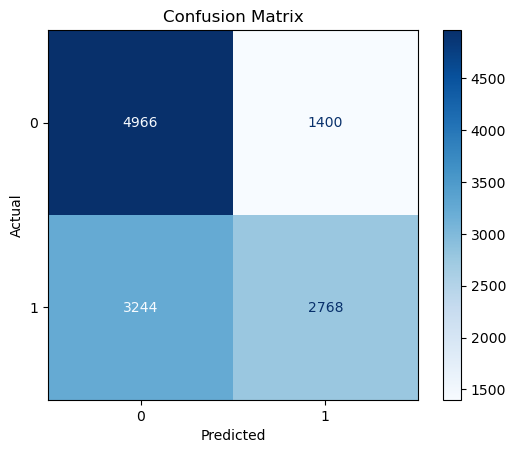

In [30]:
# Erstellen der Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred)

# Visualisieren der Konfusionsmatrix
plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('results/cvd_k100_l2_confusion_matrix_lgr.png', dpi=300)
plt.show()

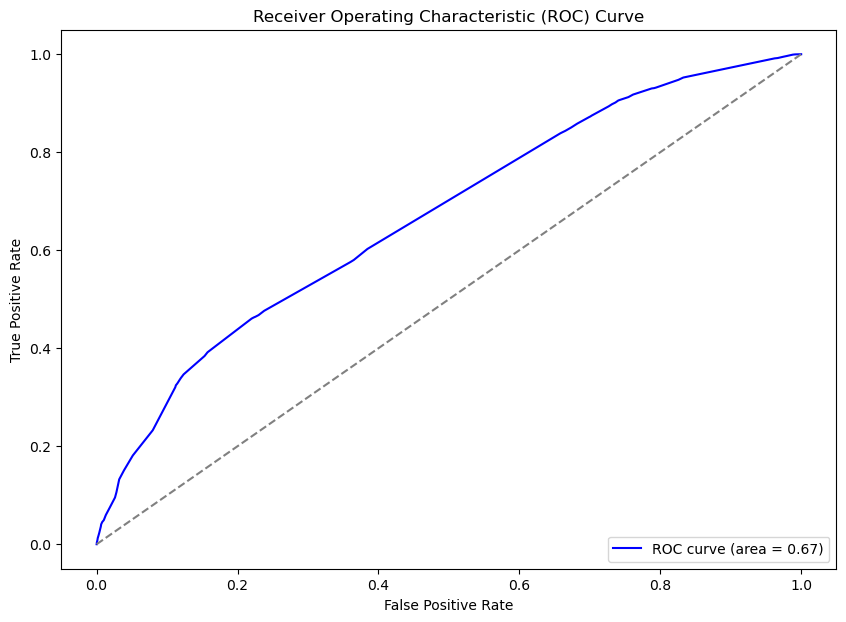

In [32]:
# ROC Kurve plotten
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('results/cvd_k100_l2_roc_curve_lgr.png', dpi=300)
plt.show()

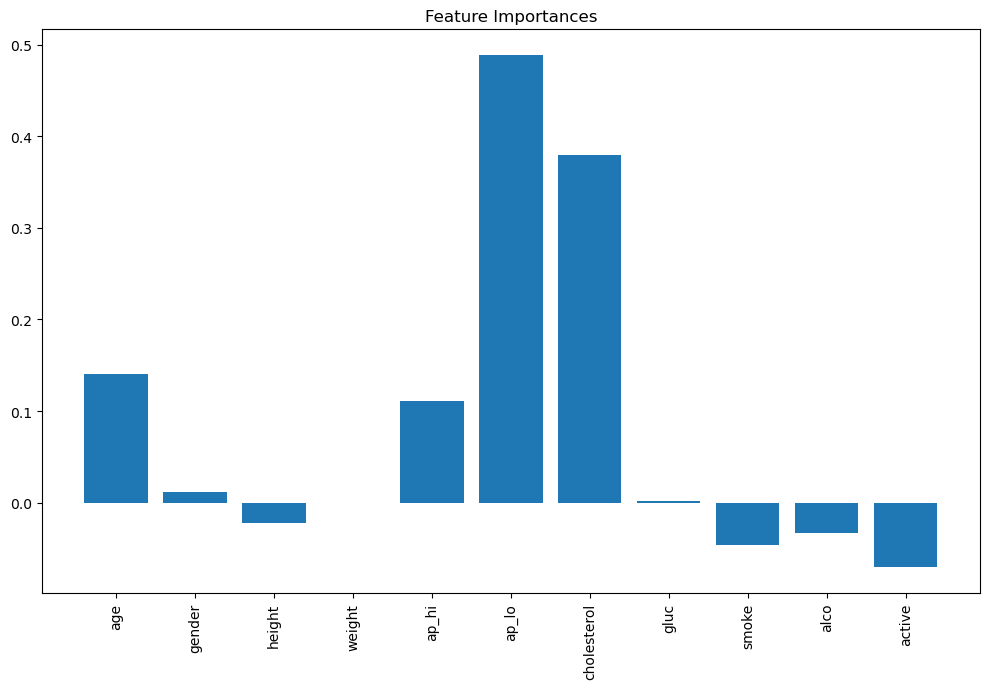

In [34]:
# Feature Importances plotten
coefficients = model.coef_[0]
features = X.columns

plt.figure(figsize=(10, 7))
plt.title('Feature Importances')
plt.bar(range(len(features)), coefficients, align='center')
plt.xticks(range(len(features)), features, rotation=90)
plt.tight_layout()
plt.savefig("results/cvd_k100_l2_feature_importances_lgr.png", dpi=300)
plt.show()

<Figure size 1600x1000 with 0 Axes>

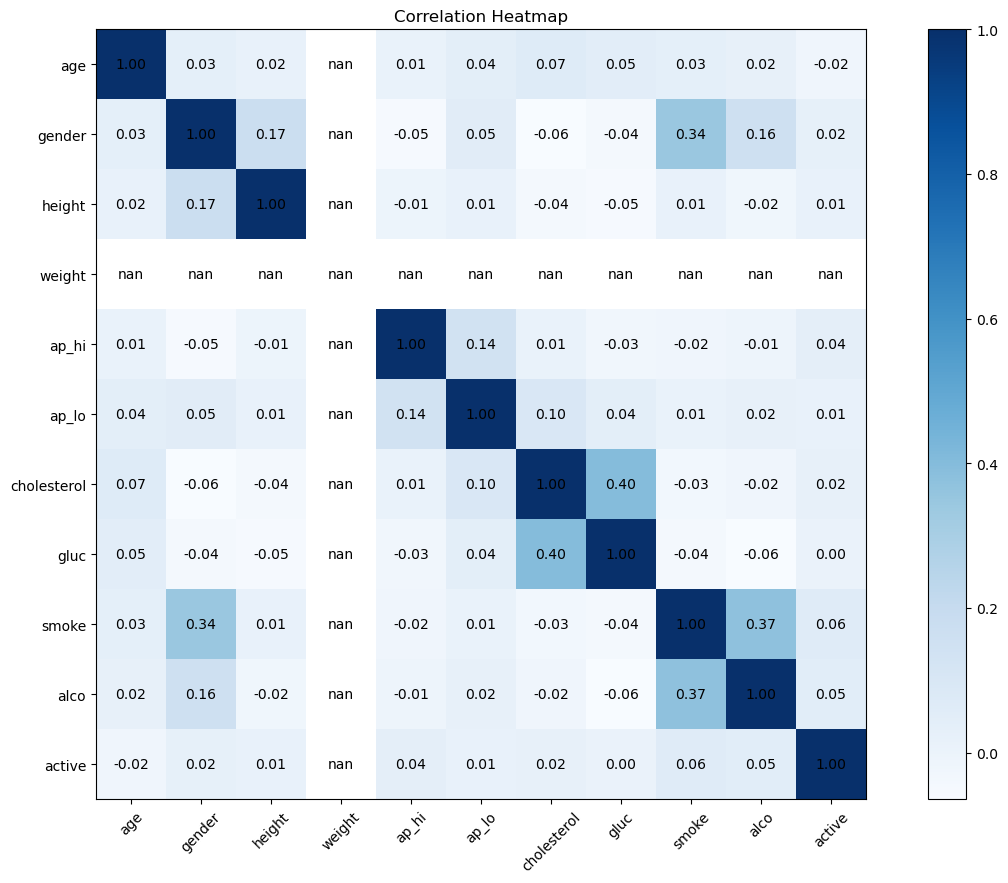

In [36]:
# Korrelations heatmap erstellen
plt.figure(figsize=(16, 10))
correlation_matrix = X.corr()

fig, ax = plt.subplots(figsize=(16, 10))
im = ax.imshow(correlation_matrix, cmap='Blues')
ax.set_xticks(np.arange(len(X.columns)))
ax.set_yticks(np.arange(len(X.columns)))
ax.set_xticklabels(X.columns, rotation=45)
ax.set_yticklabels(X.columns)

# Korrelationswerte ausgeben
for i in range(len(X.columns)):
    for j in range(len(X.columns)):
        text = ax.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="black")

plt.colorbar(im)
plt.title("Correlation Heatmap")
plt.savefig("results/cvd_k100_l2_correlation_heatmap_lgr.png", dpi=300)
plt.show()